In [1]:
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from nltk.tokenize import sent_tokenize, word_tokenize
from torch.utils.data import DataLoader, Dataset
from functools import partial
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from collections import Counter
import mplcyberpunk

In [2]:
nltk.download('punkt')
plt.style.use(["dark_background", "cyberpunk"])

[nltk_data] Downloading package punkt to /home/aleksandr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## SimpleRNN with symbol tokenize

In [3]:
def read_text(paths):
    documents = []
    for root, dirs, files in os.walk(paths):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                    lines = f.readlines()
                    content = ''.join(lines)
                    documents.append(content)
            except UnicodeDecodeError:
                print(f"Error reading file: {file_path}")
                
    return '\n'.join(documents)

spam_word = ['\ufeff', '\t', '\u2060', '¦', '«', '»', '\n', "\'"]

def proceed_vocab(text: str) -> set:
    
    extra_symbols = ['<EOS>', '<BOS>', '<UNK>']
    vocab = set()
    for char in text:
        if char not in vocab:
            vocab.add(char)
    
    for char in extra_symbols:
        vocab.add(char)
            
    return vocab

def proceed_text(symbols: list, text: str) -> None:
    new_sentences = []
    sentences = sent_tokenize(text)
    for sentence in sentences:
        
        new_sentence = []
        for symbol in sentence:
            if symbol not in symbols:
                new_sentence.append(symbol)
        
        if len(new_sentence) >= 20:
            new_sentences.append(''.join(new_sentence))
    
    return new_sentences    

In [4]:
paths = 'bbc-news-summary/'
text = read_text(paths)

In [5]:
sentences = proceed_text(spam_word, text)
train_sentences, val_sentences = train_test_split(sentences, test_size=0.3)

In [6]:
vocab_set = proceed_vocab(''.join(sentences))
char_to_ind = {char: ind for ind, char in enumerate(vocab_set)}
ind_to_char = {ind: char for char, ind in char_to_ind.items()}

In [7]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, sentences: list):
        self.data = sentences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        return self.data[index]

def collate(input_batch: list, char_to_ind: dict, mode='char'):
    if mode == 'char':
        seq_lens = [len(list(sent)) for sent in input_batch]
    elif mode == 'word':
        seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)
    
    new_batch = []
    masks = []
    for sequence in input_batch:
        new_sequence = [char_to_ind['<BOS>'], ]
        mask = [1, ]
        first = True
        for i in range(max_seq_len):
            if i < len(sequence):
                if sequence[i] in char_to_ind:
                    new_sequence.append(char_to_ind[sequence[i]])
                    mask.append(1)
                else:
                    new_sequence.append(char_to_ind['<UNK>'])
                    mask.append(0)
            else:
                if first:
                    mask.append(1)
                    first = False
                else:
                    mask.append(0)
                new_sequence.append(char_to_ind['<EOS>'])
        new_sequence.append(char_to_ind['<EOS>'])
        if len(sequence) == max_seq_len:
            mask.append(1)
        else:
            mask.append(0)
        
        new_batch.append(new_sequence)
        masks.append(mask)
        
    sequences = torch.LongTensor(new_batch)
    masks = torch.Tensor(masks)
    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:],
        'masks': masks[:, 1:]
    }
    
    return new_batch


In [8]:
train_dataset = TextDataset(train_sentences)
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=partial(collate, char_to_ind=char_to_ind))

val_dataset = TextDataset(val_sentences)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=partial(collate, char_to_ind=char_to_ind))

In [9]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab):
        super().__init__()

        self.embed_dim = 300
        self.hidden_dim = 128
        self.vocab_size = len(vocab)

        self.embed_layer = nn.Embedding(self.vocab_size, self.embed_dim)
        self.recurrent_layer = nn.RNN(self.embed_dim, self.hidden_dim, batch_first=True, num_layers=3)
        self.linear_layer = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size)

        self.tanh = nn.Tanh();
        self.dropout_layer = nn.Dropout(0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:


        x = self.embed_layer(input_batch)
        x, _ = self.recurrent_layer(x)
        x = self.dropout_layer(self.linear_layer(self.tanh(x)))
        x = self.projection(x).permute(0, 2, 1)

        return x

In [10]:
def train_model(model, criterion, optimizer, dataloader, epochs=2):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    train_history = []
    for i in range(epochs):

        for j, batch in enumerate(tqdm(dataloader)):
            optimizer.zero_grad()
            
            logits = model(batch['input_ids'].to(device))
            loss = criterion(logits.cpu(), batch['target_ids'])
            
            masked_loss = loss * batch['masks']
            total_loss = masked_loss.sum() / batch['masks'].sum()
            
            total_loss.backward()
            optimizer.step()
            
            train_history.append((i * len(dataloader) * len(batch) + j * len(batch), total_loss.item()))
            clear_output(True)
            plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
            plt.legend(); plt.grid(); plt.show()

In [11]:
model = SimpleRNN(char_to_ind)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters())

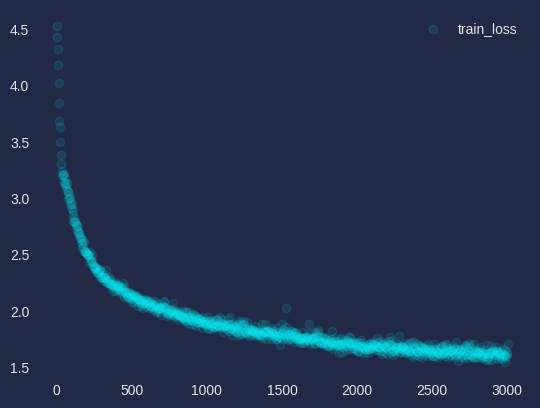

100%|██████████| 501/501 [12:15<00:00,  1.47s/it]


In [12]:
train_model(model, criterion, optimizer, train_loader)

In [13]:
def val_model(model, criterion, dataloader):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            logits = model(batch['input_ids'].to(device))
            loss = criterion(logits.cpu(), batch['target_ids'])
            
            masked_loss = loss * batch['masks']
            total_loss = masked_loss.sum() / batch['masks'].sum()
            perplexity.append(torch.exp(total_loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [14]:
val_model(model, criterion, val_loader)

100%|██████████| 215/215 [01:46<00:00,  2.02it/s]


4.983259385131126

In [15]:
text = 'A Christmas '

In [16]:
def inference(text, char_to_ind, ind_to_char, max_len=150, temperature=0.0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    with torch.no_grad():
        while True:
            
            batch = collate([text], char_to_ind)
            
            last_logits = model(batch['input_ids'].to(device))[0, :, -1]
            probs = torch.softmax(last_logits, 0).cpu()
            
            if temperature == 0.0:
                next_token = ind_to_char[torch.argmax(probs, 0).item()]
            
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(list(char_to_ind.keys()), p=probs)

            if next_token == '<EOS>' or len(text) == 100:
                break
            
            text += next_token
    return text

In [17]:
inference(text, char_to_ind, ind_to_char, temperature=0.4)

'A Christmas and the pending on the spected the services and the second and record to the claimed to '

## SimpleRNN with word tokenize

In [18]:
def proceed(text: str) -> None:
    
    counter = Counter()
    vocab = {'<EOS>', '<BOS>', '<UNK>'}
    
    sentence_tokenizer = nltk.tokenize.PunktSentenceTokenizer()
    punct_tokenizer = nltk.tokenize.TweetTokenizer()
    
    new_sentences = []
    
    for sentence in sentence_tokenizer.tokenize(text):
        
        if '"' not in sentence:
            setence = sentence.replace('\\', '')
            words = punct_tokenizer.tokenize(sentence)
            for word in words:
                counter[word] += 1

            if len(words) > 4:
                new_sentences.append(words)
    
    
    for w, c in counter.items():
        if c > 100:
            vocab.add(w)

        
    return new_sentences, vocab

In [19]:
origin_text = read_text(paths)

sentences, vocab = proceed(origin_text)
train_sentences, val_sentences = train_test_split(sentences, test_size=0.3)

word2ind = {char: ind for ind, char in enumerate(vocab)}
ind2word = {ind: char for char, ind in word2ind.items()}

In [20]:
train_dataset = TextDataset(train_sentences)
train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=partial(collate, char_to_ind=word2ind, mode='word'))

val_dataset = TextDataset(val_sentences)
val_loader = DataLoader(val_dataset, batch_size=128, collate_fn=partial(collate, char_to_ind=word2ind, mode='word'))

In [21]:
model = SimpleRNN(word2ind)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters())

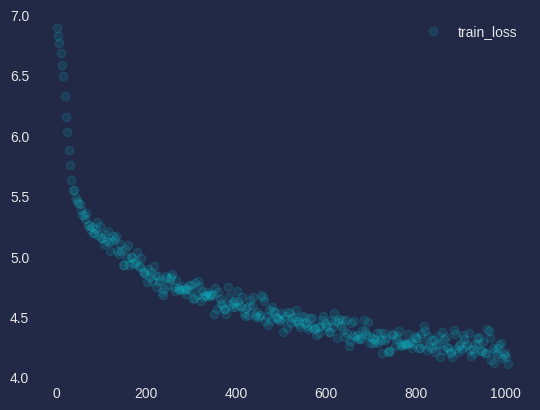

100%|██████████| 168/168 [02:29<00:00,  1.12it/s]


In [22]:
train_model(model, criterion, optimizer, train_loader)

In [23]:
val_model(model, criterion, val_loader)

100%|██████████| 72/72 [00:18<00:00,  3.85it/s]


67.74898136986627

In [24]:
def inference(model, text, word2ind, ind2word, max_len=150, temperature=0.0):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    punct_tokenizer = nltk.tokenize.TweetTokenizer()
    
    words = punct_tokenizer.tokenize(text)
    with torch.no_grad():
        while True:
            
            batch = collate([words], word2ind, mode='word')
            last_logits = model(batch['input_ids'].to(device))[0, :, -1]
            probs = torch.softmax(last_logits, 0).cpu()
            
            if temperature == 0.0:
                next_token = ind2word[torch.argmax(probs, 0).item()]
            
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(list(word2ind.keys()), p=probs)

            if next_token == '<EOS>' or len(words) == 30:
                break
            
            words.append(next_token)
    return ' '.join(words)

In [25]:
text = 'A Christmas tree '
inference(model, text, word2ind, ind2word, temperature=0.4)

'A Christmas tree of a first quarter of the US , said the company is a rise of the first time to the US of the US , the same'